In [2]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Set dataset paths
dataset_path = "/kaggle/input/chest-xray-pneumonia/chest_xray"
train_dir = os.path.join(dataset_path, "train")
val_dir = os.path.join(dataset_path, "val")
test_dir = os.path.join(dataset_path, "test")

# Image parameters
image_size = (224, 224)
batch_size = 32

# Data Generators
train_datagen_no_aug = ImageDataGenerator(rescale=1./255)
train_datagen_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator_no_aug = train_datagen_no_aug.flow_from_directory(
    train_dir, target_size=image_size, batch_size=batch_size, class_mode='binary', shuffle=True)
val_generator = val_test_datagen.flow_from_directory(
    val_dir, target_size=image_size, batch_size=batch_size, class_mode='binary', shuffle=False)
test_generator = val_test_datagen.flow_from_directory(
    test_dir, target_size=image_size, batch_size=batch_size, class_mode='binary', shuffle=False)

# Class weights to handle imbalance
pneumonia_count = len(os.listdir(os.path.join(train_dir, "PNEUMONIA")))
normal_count = len(os.listdir(os.path.join(train_dir, "NORMAL")))
total_count = pneumonia_count + normal_count
class_weights = {
    0: total_count / (2 * normal_count),
    1: total_count / (2 * pneumonia_count)
}

# Build VGG16 model with Grad-CAM output
def build_vgg16_with_gradcam():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    # Grad-CAM model (returns conv layer and output)
    grad_model = tf.keras.Model(
        inputs=base_model.input,
        outputs=[base_model.get_layer("block5_conv3").output, base_model.output]
    )

    # Full model for training
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=SGD(learning_rate=1e-4, momentum=0.9),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model, grad_model

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [3]:
# Grad-CAM heatmap generation
def grad_cam(model, grad_model, img_array, class_idx=0):
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        tape.watch(conv_output)
        class_output = predictions[:, class_idx]
    
    grads = tape.gradient(class_output, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_output = conv_output[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_output), axis=-1)
    
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) + 1e-8
    return heatmap

# Overlay heatmap on image
def visualize_gradcam(img_path, model, grad_model, image_size=(224, 224)):
    img = image.load_img(img_path, target_size=image_size)
    img_array = image.img_to_array(img)
    input_array = np.expand_dims(img_array, axis=0) / 255.0

    heatmap = grad_cam(model, grad_model, input_array)

    # Resize heatmap to image size
    heatmap = np.uint8(255 * heatmap)
    heatmap = tf.image.resize(np.expand_dims(heatmap, axis=-1), image_size).numpy().astype(np.uint8)
    heatmap = np.squeeze(heatmap)

    # Plot image and heatmap overlay
    plt.figure(figsize=(6, 6))
    plt.imshow(img_array.astype('uint8') / 255.0)
    plt.imshow(heatmap, cmap='jet', alpha=0.4)
    plt.axis('off')
    plt.title('Grad-CAM')
    plt.show()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Build model
model, grad_model = build_vgg16_with_gradcam()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
history_no_aug = model.fit(
    train_generator_no_aug,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 502ms/step - accuracy: 0.6517 - loss: 1.0315 - val_accuracy: 0.6875 - val_loss: 0.9837 - learning_rate: 1.0000e-04
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 45s 265ms/step - accuracy: 0.7897 - loss: 0.7782 - val_accuracy: 0.7500 - val_loss: 0.8933 - learning_rate: 1.0000e-04
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 46s 267ms/step - accuracy: 0.8444 - loss: 0.6956 - val_accuracy: 0.7500 - val_loss: 0.8258 - learning_rate: 1.0000e-04
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 45s 261ms/step - accuracy: 0.8572 - loss: 0.6650 - val_accuracy: 0.7500 - val_loss: 0.8312 - learning_rate: 1.0000e-04
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 44s 260ms/step - accuracy: 0.8773 - loss: 0.6271 - val_accuracy: 0.7500 - val_loss: 0.8501 - learning_rate: 1.0000e-04
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 45s 264ms/step - accuracy: 0.8859 - loss: 0.6091 - val_accuracy: 0.7500 - val_loss: 0.8600 - learning_rate: 1.0000e-04
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 45s 265ms/step - 

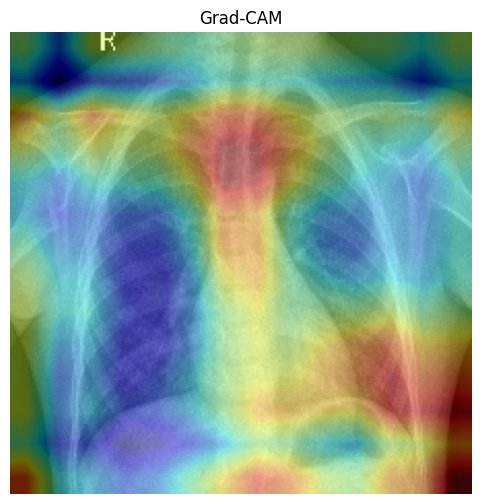

In [5]:
sample_image_path ='/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0010-0001.jpeg'  # Change path as needed
visualize_gradcam(sample_image_path, model, grad_model)

In [7]:
model.save("/kaggle/working/vgg16_model.h5")  # Saves to the working directory
import os
if os.path.exists("/kaggle/working/vgg16_model.h5"):
    print("✅ Model saved successfully!")
else:
    print("❌ Model not saved.")


✅ Model saved successfully!


In [16]:
from tensorflow.keras.models import load_model

loaded_model = load_model("/kaggle/working/vgg16_model.h5")
print(loaded_model.summary())  # Verify the architecture


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,848,323 (56.64 MB)

 Trainable params: 132,609 (518.00 KB)

 Non-trainable params: 14,715,712 (56.14 MB)

 Optimizer params: 2 (12.00 B)

None


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━

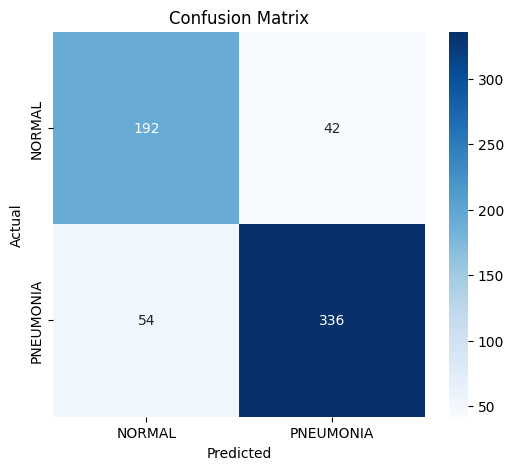

In [11]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Load the trained model
model_path = "/kaggle/working/vgg16_model.h5"  # Update if needed
loaded_model = load_model(model_path)

# Define class names (Assuming binary classification: NORMAL vs PNEUMONIA)
class_names = ["NORMAL", "PNEUMONIA"]

# Test dataset directory
test_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"  # Update this path

true_labels = []
pred_labels = []

# Loop through test images
for class_idx, class_name in enumerate(class_names):
    class_folder = os.path.join(test_dir, class_name)
    
    for image_name in os.listdir(class_folder):
        image_path = os.path.join(class_folder, image_name)
        
        # Load and preprocess the image (WITHOUT background removal)
        img = image.load_img(image_path, target_size=(224, 224))  # Resize to match model input
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array /= 255.0  # Normalize

        # Make prediction
        prediction = loaded_model.predict(img_array)
        pred_class = int(prediction[0][0] > 0.5)  # Binary classification (Threshold at 0.5)

        true_labels.append(class_idx)
        pred_labels.append(pred_class)

# Generate and print classification report
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=class_names))

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import cv2

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


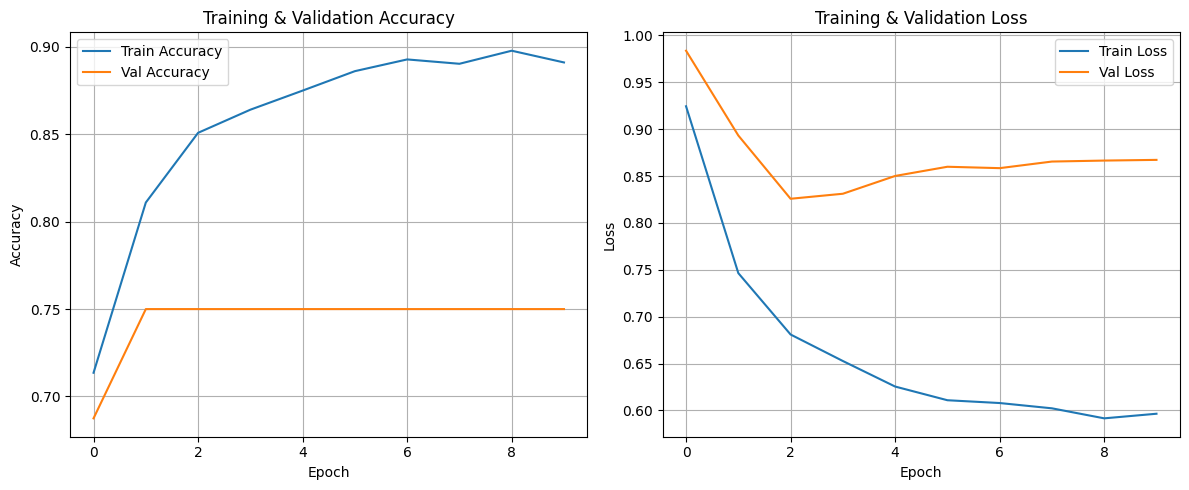

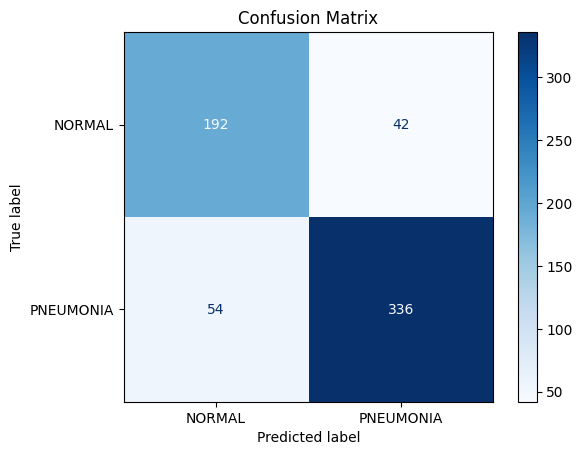

Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.78      0.82      0.80       234
   PNEUMONIA       0.89      0.86      0.88       390

    accuracy                           0.85       624
   macro avg       0.83      0.84      0.84       624
weighted avg       0.85      0.85      0.85       624



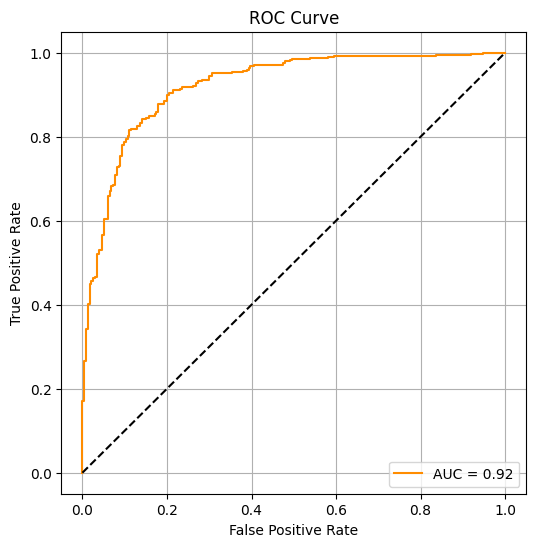

In [18]:
# Predict on test set
y_pred_prob = loaded_model.predict(test_generator, verbose=0)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Accuracy & Loss Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_no_aug.history['accuracy'], label='Train Accuracy')
plt.plot(history_no_aug.history['val_accuracy'], label='Val Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history_no_aug.history['loss'], label='Train Loss')
plt.plot(history_no_aug.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# AUC-ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc, color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()






In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load the trained model
model_path = "/kaggle/working/vgg16_model.h5"  # Update if needed
loaded_model = load_model(model_path)

# Define class names (Assuming binary classification: Normal vs Pneumonia)
class_names = ["Normal", "Pneumonia"]

# Image Path
image_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0001-0001.jpeg"  # Update path

# Load and preprocess the image
img = image.load_img(image_path, target_size=(224, 224))  # Resize to match VGG16 input
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize

# Make prediction
prediction = loaded_model.predict(img_array)
predicted_class = class_names[int(prediction[0][0] > 0.5)]  # Binary classification

# Display the image with prediction
plt.imshow(cv2.imread(image_path)[..., ::-1])  # Convert BGR to RGB
plt.title(f"Predicted: {predicted_class}")
plt.axis("off")
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

def convert_to_functional(sequential_model):
    inputs = tf.keras.Input(shape=(224, 224, 3))
    outputs = sequential_model(inputs)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

def generate_grad_cam(model, img_array, last_conv_layer_name="dense_3"):
    # Access the last convolutional layer by its name
    last_conv_layer = model.get_layer(last_conv_layer_name)
    
    grad_model = tf.keras.Model(
        inputs=model.input,
        outputs=[last_conv_layer.output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_output, prediction = grad_model(img_array)
        loss = prediction[:, 0]  # Assuming binary classification (Pneumonia vs Normal)

    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_output = conv_output[0]

    # Create heatmap
    heatmap = conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap.numpy()
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = heatmap / np.max(heatmap)  # Normalize the heatmap
    return heatmap

def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img_resized = cv2.resize(img, (224, 224)) / 255.0  # Resize and normalize
    img_array = np.expand_dims(img_resized, axis=0)  # Add batch dimension
    return img_array, img_resized

def display_grad_cam(img_path, model, last_conv_layer_name="block5_conv3"):
    # Preprocess image
    img_array, img_resized = preprocess_image(img_path)
    
    # Convert Sequential model to Functional if needed
    functional_model = convert_to_functional(model)
    _ = functional_model.predict(img_array)  # Build model graph

    # Generate Grad-CAM heatmap
    heatmap = generate_grad_cam(functional_model, img_array, last_conv_layer_name)

    # Apply color map to the heatmap (BGR format)
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

    # Normalize img_resized for proper overlay (scaled to [0, 255])
    img_resized_normalized = np.uint8(img_resized * 255)

    # Overlay the heatmap on top of the image
    overlay = cv2.addWeighted(img_resized_normalized, 0.6, heatmap_colored, 0.4, 0)

    # Convert BGR to RGB for display with matplotlib
    overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

    # Plot the image with overlay
    plt.figure(figsize=(6, 6))
    plt.imshow(overlay_rgb)
    plt.title("Grad-CAM on Pneumonia X-ray")
    plt.axis("off")
    plt.show()

import cv2
import numpy as np

def preprocess_image(img_path):
    print(f"Attempting to load image from: {img_path}")  # Print the image path
    img = cv2.imread(img_path)

    if img is None:
        print(f"Error: Image at path {img_path} could not be loaded. Please check the file path.")
        return None, None

    print("Image loaded successfully.")
    img_resized = cv2.resize(img, (224, 224)) / 255.0  # Resize and normalize
    img_array = np.expand_dims(img_resized, axis=0)  # Add batch dimension
    return img_array, img_resized

# Example usage:
img_path = "/.jpg"  # Update with your actual image path
img_array, img_resized = preprocess_image(img_path)

# If the image couldn't be loaded, exit the program
if img_array is None:
    print("Exiting due to image loading error.")
else:
    # Proceed with Grad-CAM generation
    print("Proceeding with Grad-CAM visualization.")


In [ ]:
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Image at path {img_path} could not be loaded. Please check the file path.")
    img_resized = cv2.resize(img, (224, 224)) / 255.0  # Resize and normalize
    img_array = np.expand_dims(img_resized, axis=0)  # Add batch dimension
    return img_array, img_resized


In [ ]:
# Load and preprocess image
img_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg"
img = cv2.imread(img_path)
img_resized = cv2.resize(img, (224, 224)) / 255.0
img_array = np.expand_dims(img_resized, axis=0)

# ✅ Convert Sequential model to Functional and call it
functional_model = convert_to_functional(vgg_no_aug)
_ = functional_model.predict(img_array)  # Important: this builds the graph

# Generate Grad-CAM heatmap
heatmap = generate_grad_cam(functional_model, img_array)

# Apply color map to the heatmap (BGR format)
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

# Make sure img_resized is in the proper scale (0 to 1 range if necessary)
img_resized_normalized = np.uint8(img_resized * 255)  # if img_resized is normalized between 0 and 1

# Overlay the heatmap on top of the image
overlay = cv2.addWeighted(img_resized_normalized, 0.6, heatmap_colored, 0.4, 0)

# Convert BGR to RGB for display with matplotlib
overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

# Plot the image with overlay
plt.figure(figsize=(6, 6))
plt.imshow(overlay_rgb)
plt.title("Grad-CAM on Pneumonia X-ray")
plt.axis("off")
plt.show()

In [3]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Build VGG16 Model
def build_vgg16():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False
    
    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model
# Train model with augmentation
vgg_aug = build_vgg16()
history_aug = vgg_aug.fit(
    train_generator_aug,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weights,
    callbacks=[early_stopping]
)


NameError: name 'train_generator_aug' is not defined

In [ ]:
vgg_aug.save("/kaggle/working/vgg16_aug_model.h5")  # Saves to the working directory
import os
if os.path.exists("/kaggle/working/vgg16_aug_model.h5"):
    print("✅ Model saved successfully!")
else:
    print("❌ Model not saved.")


In [ ]:
from tensorflow.keras.models import load_model

loaded_model = load_model("/kaggle/working/vgg16_aug_model.h5")
print(loaded_model.summary())  # Verify the architecture


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load the trained model
model_path = "/kaggle/working/vgg16_aug_model.h5"  # Update if needed
loaded_model = load_model(model_path)

# Define class names (Assuming binary classification: Normal vs Pneumonia)
class_names = ["Normal", "Pneumonia"]

# Image Path
image_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0001-0001.jpeg"  # Update path

# Load and preprocess the image
img = image.load_img(image_path, target_size=(224, 224))  # Resize to match VGG16 input
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize

# Make prediction
prediction = loaded_model.predict(img_array)
predicted_class = class_names[int(prediction[0][0] > 0.5)]  # Binary classification

# Display the image with prediction
plt.imshow(cv2.imread(image_path)[..., ::-1])  # Convert BGR to RGB
plt.title(f"Predicted: {predicted_class}")
plt.axis("off")
plt.show()


In [ ]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Load the trained model
model_path = "/kaggle/working/vgg16_aug_model.h5"  # Update if needed
loaded_model = load_model(model_path)

# Define class names (Assuming binary classification: NORMAL vs PNEUMONIA)
class_names = ["NORMAL", "PNEUMONIA"]

# Test dataset directory
test_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"  # Update this path

true_labels = []
pred_labels = []

# Loop through test images
for class_idx, class_name in enumerate(class_names):
    class_folder = os.path.join(test_dir, class_name)
    
    for image_name in os.listdir(class_folder):
        image_path = os.path.join(class_folder, image_name)
        
        # Load and preprocess the image (WITHOUT background removal)
        img = image.load_img(image_path, target_size=(224, 224))  # Resize to match model input
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array /= 255.0  # Normalize

        # Make prediction
        prediction = loaded_model.predict(img_array)
        pred_class = int(prediction[0][0] > 0.5)  # Binary classification (Threshold at 0.5)

        true_labels.append(class_idx)
        pred_labels.append(pred_class)

# Generate and print classification report
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=class_names))

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

def build_resnet50(fine_tune_layers=5):
    """Builds a ResNet50-based binary classifier with fine-tuning and better regularization."""
    
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

    # Fine-tune only the last 'fine_tune_layers' layers
    for layer in base_model.layers[-fine_tune_layers:]:
        layer.trainable = True
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),  # Reduces parameters, prevents overfitting
        Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),  # L2 regularization
        Dropout(0.5),  # Prevents overfitting
        Dense(1, activation="sigmoid")  # Binary classification (Pneumonia vs Normal)
    ])
    
    optimizer = Adam(learning_rate=1e-5)  # Smaller LR for stable training
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    
    return model


In [ ]:
# Train Models (With and Without Augmentation)
resnet_no_aug = build_resnet50() 
history_no_aug = resnet_no_aug.fit(train_generator_no_aug, validation_data=val_generator, epochs=10, class_weight=class_weights)

In [ ]:
resnet_no_aug.save("/kaggle/working/resnet_no_aug_model.h5")  # Saves to the working directory
import os
if os.path.exists("/kaggle/working/resnet_no_aug_model.h5"):
    print("✅ Model saved successfully!")
else:
    print("❌ Model not saved.")


In [ ]:
from tensorflow.keras.models import load_model

loaded_model = load_model("/kaggle/working/resnet_no_aug_model.h5")
print(loaded_model.summary())  # Verify the architecture


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load the trained model
model_path = "/kaggle/working/resnet_no_aug_model.h5"  # Update if needed
loaded_model = load_model(model_path)

# Define class names (Assuming binary classification: Normal vs Pneumonia)
class_names = ["Normal", "Pneumonia"]

# Image Path
image_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0001-0001.jpeg"  # Update path

# Load and preprocess the image
img = image.load_img(image_path, target_size=(224, 224))  # Resize to match VGG16 input
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize

# Make prediction
prediction = loaded_model.predict(img_array)
predicted_class = class_names[int(prediction[0][0] > 0.5)]  # Binary classification

# Display the image with prediction
plt.imshow(cv2.imread(image_path)[..., ::-1])  # Convert BGR to RGB
plt.title(f"Predicted: {predicted_class}")
plt.axis("off")
plt.show()


In [ ]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Load the trained model
model_path = "/kaggle/working/resnet_no_aug_model.h5"  # Update if needed
loaded_model = load_model(model_path)

# Define class names (Assuming binary classification: NORMAL vs PNEUMONIA)
class_names = ["NORMAL", "PNEUMONIA"]

# Test dataset directory
test_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"  # Update this path

true_labels = []
pred_labels = []

# Loop through test images
for class_idx, class_name in enumerate(class_names):
    class_folder = os.path.join(test_dir, class_name)
    
    for image_name in os.listdir(class_folder):
        image_path = os.path.join(class_folder, image_name)
        
        # Load and preprocess the image (WITHOUT background removal)
        img = image.load_img(image_path, target_size=(224, 224))  # Resize to match model input
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array /= 255.0  # Normalize

        # Make prediction
        prediction = loaded_model.predict(img_array)
        pred_class = int(prediction[0][0] > 0.5)  # Binary classification (Threshold at 0.5)

        true_labels.append(class_idx)
        pred_labels.append(pred_class)

# Generate and print classification report
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=class_names))

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
resnet_aug = build_resnet50()
history_aug = resnet_aug.fit(train_generator_aug, validation_data=val_generator, epochs=10, class_weight=class_weights)

In [ ]:
resnet_aug.save("/kaggle/working/resnet_aug_model.h5")  # Saves to the working directory
import os
if os.path.exists("/kaggle/working/resnet_aug_model.h5"):
    print("✅ Model saved successfully!")
else:
    print("❌ Model not saved.")


In [ ]:
from tensorflow.keras.models import load_model

loaded_model = load_model("/kaggle/working/resnet_aug_model.h5")
print(loaded_model.summary())  # Verify the architecture


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load the trained model
model_path = "/kaggle/working/resnet_aug_model.h5"  # Update if needed
loaded_model = load_model(model_path)

# Define class names (Assuming binary classification: Normal vs Pneumonia)
class_names = ["Normal", "Pneumonia"]

# Image Path
image_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0001-0001.jpeg"  # Update path

# Load and preprocess the image
img = image.load_img(image_path, target_size=(224, 224))  # Resize to match VGG16 input
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize

# Make prediction
prediction = loaded_model.predict(img_array)
predicted_class = class_names[int(prediction[0][0] > 0.5)]  # Binary classification

# Display the image with prediction
plt.imshow(cv2.imread(image_path)[..., ::-1])  # Convert BGR to RGB
plt.title(f"Predicted: {predicted_class}")
plt.axis("off")
plt.show()


In [ ]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Load the trained model
model_path = "/kaggle/working/resnet_aug_model.h5"  # Update if needed
loaded_model = load_model(model_path)

# Define class names (Assuming binary classification: NORMAL vs PNEUMONIA)
class_names = ["NORMAL", "PNEUMONIA"]

# Test dataset directory
test_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"  # Update this path

true_labels = []
pred_labels = []

# Loop through test images
for class_idx, class_name in enumerate(class_names):
    class_folder = os.path.join(test_dir, class_name)
    
    for image_name in os.listdir(class_folder):
        image_path = os.path.join(class_folder, image_name)
        
        # Load and preprocess the image (WITHOUT background removal)
        img = image.load_img(image_path, target_size=(224, 224))  # Resize to match model input
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array /= 255.0  # Normalize

        # Make prediction
        prediction = loaded_model.predict(img_array)
        pred_class = int(prediction[0][0] > 0.5)  # Binary classification (Threshold at 0.5)

        true_labels.append(class_idx)
        pred_labels.append(pred_class)

# Generate and print classification report
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=class_names))

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def grad_cam(model, img_array, layer_name="block5_conv3"):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        loss = predictions[:, 0]  # Adjust index for different classes

    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_sum(grads, axis=(0, 1))  # Reduce sum instead of mean
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)

    heatmap = np.maximum(heatmap, 0)  # ReLU to keep positive values
    heatmap = cv2.resize(heatmap[0], (224, 224))  # Resize to match input
    heatmap = cv2.normalize(heatmap, None, 0, 1, cv2.NORM_MINMAX)  # Normalize

    return heatmap

# Load image
img = cv2.imread("/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg")
img_resized = cv2.resize(img, (224, 224)) / 255.0
img_array = np.expand_dims(img_resized, axis=0)

# Run Grad-CAM
heatmap = grad_cam(loaded_model_2, img_array)

# Display Image + Heatmap
plt.imshow(img_resized)
plt.imshow(heatmap, cmap="jet", alpha=0.5)
plt.axis("off")
plt.show()
